# 04. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import src.utils as utils
from datetime import date, datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train_init = utils.pickle_load('data/processed/train.pkl').reset_index(drop = True)
df_test_init = utils.pickle_load('data/processed/test.pkl').reset_index(drop = True)

In [3]:
# Separate y column or dependent variable
y_train = df_train_init.tracks_popularity.values
y_test = df_test_init.tracks_popularity.values

In [4]:
# Melakukan grouping untuk kolom umur dan hari debut untuk mengatasi missing values yg jumlahnya banyak

def cat_age(age):
    if age <= 20:
        cat = '<20'
    elif 20 < age <= 30:
        cat = '25-30'
    elif age > 30:
        cat = '>30'
    else:
        cat = 'unknown'

    return cat

def cat_days_after_debut(days):
    if days <= 365:
        cat = '<1year'
    elif 365 < days <= 365 * 5:
        cat = '1-5years'
    elif 365 * 5 < days <= 365 * 10:
        cat = '5-10years'
    elif days > 365 * 10:
        cat = '>10years'
    else:
        cat = 'unknown'
        
    return cat

    

In [5]:
def labelencoder(train, test, feature):

    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    test[feature] = le.transform(test[feature])

    return train[feature], test[feature]

def onehotencoder(train, test, feature):
    
    ohe = OneHotEncoder()
    ohe.fit(train[[feature]])
    train_encoded = pd.DataFrame(ohe.transform(train[[feature]]).toarray())
    train_encoded.columns = ohe.get_feature_names([feature])

    test_encoded = pd.DataFrame(ohe.transform(test[[feature]]).toarray())
    test_encoded.columns = ohe.get_feature_names([feature])

    return train_encoded, test_encoded


In [6]:
def preprocessing(train, test):

    # Mengganti kolom days_after_debut dan mean_age menjadi kolom kategorikal
    train['cat_age'] = train.apply(lambda row: cat_age(row['mean_age']), axis=1)
    train['cat_days_debut'] = train.apply(lambda row: cat_age(row['days_after_debut']), axis=1)
    test['cat_age'] = test.apply(lambda row: cat_age(row['mean_age']), axis=1)
    test['cat_days_debut'] = test.apply(lambda row: cat_age(row['days_after_debut']), axis=1)

    # Drop kolom explicit dan time_signature karena dari EDA dianggap tidak berpengaruh
    train.drop(['mean_age', 'days_after_debut', 'explicit', 'time_signature', 'members', 'tracks_popularity'],axis = 1, inplace=True)
    test.drop(['mean_age', 'days_after_debut', 'explicit', 'time_signature', 'members', 'tracks_popularity'],axis = 1, inplace=True)

    # creating instance of labelencoder
    train['key'], test['key'] = labelencoder(train, test, feature = 'key')

    train_modality_encoded, test_modality_encoded = onehotencoder(train, test, feature='modality')
    train_age_encoded, test_age_encoded = onehotencoder(train, test, feature='cat_age')
    train_debutdays_encoded, test_debutdays_encoded = onehotencoder(train, test, feature='cat_days_debut')
    train_company_encoded, test_company_encoded = onehotencoder(train, test, feature='big5_company')

    train.drop(['modality', 'big5_company', 'cat_age', 'cat_days_debut'], axis = 1, inplace=True)
    train_concat = pd.concat([train, train_modality_encoded, train_company_encoded, train_age_encoded, train_debutdays_encoded], axis = 1)

    test.drop(['modality', 'big5_company', 'cat_age', 'cat_days_debut'], axis = 1, inplace=True)
    test_concat = pd.concat([test, test_modality_encoded, test_company_encoded, test_age_encoded, test_debutdays_encoded], axis = 1)

    return train_concat, test_concat

In [7]:
X_train, X_test = preprocessing(df_train_init, df_test_init)
#X_test = preprocessing(df_test_init)

In [8]:
X_train.isna().sum().sum()

0

In [9]:
len(X_test.columns)

26

# 05. Modelling

In [10]:
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [11]:
# baseline MSE
from sklearn.metrics import mean_squared_error

baseline_pred = np.mean(y_train)
print(baseline_pred)
baseline_mse = mean_squared_error(y_train, 
                                  np.ones(len(y_train)) * baseline_pred)
print(baseline_mse)

51.15055079559364
247.1878607737356


## a. Linear Model (OLS, Ridge and Lasso Regularization)

In [12]:
def fit_model(X_train, y_train,
              X_test, y_test):
    # 1. Buat objek
    lr = LinearRegression()

    # 2. Lakukan cross-val
    scores = cross_val_score(estimator = lr,
                             X = X_train,
                             y = y_train,
                             cv = 5,
                             scoring = "neg_mean_squared_error")
    
    cv_score = - np.mean(scores)
    
    # 3. Fit model
    lr.fit(X = X_train,
           y = y_train)
    
    # 4. Cari train score
    y_train_pred = lr.predict(X_train)
    train_score = mean_squared_error(y_train, y_train_pred)
    
    # 4. Cari test score
    y_test_pred = lr.predict(X_test)
    test_score = mean_squared_error(y_test, y_test_pred)

    # 5. Ekstrak coefficient
    coef_ = lr.coef_
    intercept_ = lr.intercept_
    lr_params = np.append(coef_, intercept_)

    lr_params_df = pd.DataFrame(lr_params,
                                index = list(X_train.columns) + ["constant"],
                                columns = ["coefficient"])
    
    return lr, train_score, cv_score, test_score, lr_params_df


In [13]:
lr, train_score, cv_score, test_score, lr_params_df = fit_model(X_train = X_train,
                                                                y_train = y_train,
                                                                X_test = X_test,
                                                                y_test = y_test)
print(f"train score: {train_score:.3f}, cv score: {cv_score:.3f}, test_score: {test_score:.3f}")

train score: 139.234, cv score: 143.940, test_score: 136.595


### Ridge Regression

In [14]:
# Import Ridge
from sklearn.linear_model import Ridge
# Import grid search
from sklearn.model_selection import GridSearchCV

In [15]:
# Buat model & parameter model yang ingin divariasikan
ridge = Ridge()

alphas = [0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 
          12.5, 15.0, 17.5, 30.0, 50.0]
param_space = {"alpha": alphas}

# Lakukan grid search dengan CV
cv_ridge = GridSearchCV(estimator = ridge,
                        param_grid = param_space,
                        scoring = "neg_mean_squared_error",
                        cv = 5)

# Fit searching
cv_ridge.fit(X = X_train,
             y = y_train)

best_param = cv_ridge.best_params_

cv_ridge.best_params_["alpha"]

2.5

In [16]:
# Buat objek ridge
best_ridge = Ridge(alpha = cv_ridge.best_params_["alpha"])

# Fit model
best_ridge.fit(X = X_train,
               y = y_train)

list_coef = X_train.columns.tolist() + ['constant']
ridge_coef = list(best_ridge.coef_)
ridge_coef.append(best_ridge.intercept_)

best_param_ridge= pd.DataFrame(
    {'coef': list_coef,
     'ridge': list(ridge_coef)
    })
best_param_ridge.set_index('coef', inplace=True)

In [17]:
# Predict
y_pred_train = best_ridge.predict(X_train)

# MSE
mse_train_ridge = mean_squared_error(y_train, y_pred_train)
mse_cv_ridge = -cv_ridge.best_score_

print(f"MSE Train :{mse_train_ridge:.4f}")
print(f"MSE CV    :{mse_cv_ridge:.4f}")

MSE Train :139.4287
MSE CV    :143.6503


### Regularisasi Lasso

In [18]:
# Import Lasso
from sklearn.linear_model import Lasso

In [19]:
# Buat model & parameter model yang ingin divariasikan
lasso = Lasso()

param_space = {"alpha": alphas}

# Lakukan grid search dengan CV
cv_lasso = GridSearchCV(estimator = lasso,
                        param_grid = param_space,
                        scoring = "neg_mean_squared_error",
                        cv = 5)

# Fit searching
cv_lasso.fit(X = X_train,
             y = y_train)

cv_lasso.best_params_

{'alpha': 1.0}

In [20]:
# Buat objek baru
best_lasso = Lasso(alpha = cv_lasso.best_params_["alpha"])

# Fit model
best_lasso.fit(X = X_train,
               y = y_train)

lasso_coef = list(best_lasso.coef_)
lasso_coef.append(best_lasso.intercept_)

best_param_lasso= pd.DataFrame(
    {'coef': list_coef,
     'lasso': list(lasso_coef)
    })
best_param_lasso.set_index('coef', inplace=True)


In [21]:
# Predict
y_pred_train = best_lasso.predict(X_train)

# MSE
mse_train_lasso = mean_squared_error(y_train, y_pred_train)
mse_cv_lasso = -cv_lasso.best_score_

print(f"MSE Train :{mse_train_lasso:.4f}")
print(f"MSE CV    :{mse_cv_lasso:.4f}")

MSE Train :153.9735
MSE CV    :155.0665


In [22]:
mse_train_lm = [train_score, mse_train_ridge, mse_train_lasso]
mse_cv_lm = [cv_score, mse_cv_ridge, mse_cv_lasso]
indexes = ["OLS", "Ridge", "Lasso"]

summary_lm = pd.DataFrame({"MSE Train": mse_train_lm,
                           "MSE CV": mse_cv_lm},
                          index = indexes)
summary_lm

,MSE Train,MSE CV
OLS,139.234298,143.940076
Ridge,139.428718,143.650342
Lasso,153.973524,155.066496


## b. Model Ensemble

### Decision Tree

In [23]:
params = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
          "max_features": ["sqrt", "log2"]}

# Buat gridsearch
dec_tree = DecisionTreeRegressor(random_state = 123, criterion =  'squared_error')

tree_cv = GridSearchCV(estimator = dec_tree,
                       param_grid = params,
                       cv = 5,
                       scoring = "neg_mean_squared_error")

In [24]:
# Fit grid search cv
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13],
                         'max_features': ['sqrt', 'log2']},
             scoring='neg_mean_squared_error')

In [25]:
# Best params
tree_cv.best_params_

{'max_depth': 4, 'max_features': 'sqrt'}

In [26]:
# Refit the bagging tree
dec_tree = DecisionTreeRegressor(max_depth = tree_cv.best_params_["max_depth"],
                             max_features = tree_cv.best_params_["max_features"],
                             random_state = 123)

dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, max_features='sqrt', random_state=123)

In [27]:
# Predict
y_pred_train = dec_tree.predict(X_train)

# MSE
mse_train_dt = mean_squared_error(y_train, y_pred_train)
mse_cv_dt = -tree_cv.best_score_

print(f"MSE Train :{mse_train_dt:.4f}")
print(f"MSE CV    :{mse_cv_dt:.4f}")

MSE Train :129.5753
MSE CV    :144.7733


### Dengan Bagging

In [28]:
from sklearn.ensemble import BaggingRegressor

In [29]:
B = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
params = {"n_estimators": B}

# Buat gridsearch
tree = DecisionTreeRegressor()
bagging_tree = BaggingRegressor(base_estimator = tree,
                                random_state = 123)

bagging_cv = GridSearchCV(estimator = bagging_tree,
                          param_grid = params,
                          cv = 5,
                          scoring = "neg_mean_squared_error")

In [30]:
# Fit grid search cv
bagging_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                                        random_state=123),
             param_grid={'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350,
                                          400, 450, 500]},
             scoring='neg_mean_squared_error')

In [31]:
# Best params
bagging_cv.best_params_

{'n_estimators': 200}

In [32]:
# Refit the bagging tree
bagging_tree = BaggingRegressor(base_estimator = tree,
                                n_estimators = bagging_cv.best_params_["n_estimators"],
                                random_state = 123)

bagging_tree.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=200,
                 random_state=123)

In [33]:
# Predict
y_pred_train = bagging_tree.predict(X_train)

# MSE
mse_train_bg = mean_squared_error(y_train, y_pred_train)
mse_cv_bg = -bagging_cv.best_score_

print(f"MSE Train :{mse_train_bg:.4f}")
print(f"MSE CV    :{mse_cv_bg:.4f}")

MSE Train :16.1748
MSE CV    :108.0991


### Random Forest Regression

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
params = {"n_estimators": B,
          "max_features": ["sqrt", "log2"]}

# Buat gridsearch
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                random_state = 123)

rf_tree_cv = GridSearchCV(estimator = rf_tree,
                          param_grid = params,
                          cv = 5,
                          scoring = "neg_mean_absolute_error")

In [36]:
# Fit grid search cv
rf_tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350,
                                          400, 450, 500]},
             scoring='neg_mean_absolute_error')

In [37]:
# Best params
rf_tree_cv.best_params_

{'max_features': 'sqrt', 'n_estimators': 350}

In [38]:
# Refit the Random Forest
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                max_features = rf_tree_cv.best_params_["max_features"],
                                n_estimators = rf_tree_cv.best_params_["n_estimators"],
                                random_state = 123)

rf_tree.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=350, random_state=123)

In [39]:
# Predict
y_pred_train = rf_tree.predict(X_train)

# MSE
mse_train_rf = mean_squared_error(y_train, y_pred_train)
mse_cv_rf = -rf_tree_cv.best_score_

print(f"MSE Train :{mse_train_rf:.4f}")
print(f"MSE CV    :{mse_cv_rf:.4f}")

MSE Train :16.2547
MSE CV    :8.3683


In [40]:
mse_train = [mse_train_dt, mse_train_bg, mse_train_rf]
mse_cv = [mse_cv_dt, mse_cv_bg, mse_cv_rf]
indexes = ["decision tree", "bagging", "random forest"]

summary_ensemble = pd.DataFrame({"MSE Train": mse_train,
                           "MSE CV": mse_cv},
                          index = indexes)
summary_ensemble

,MSE Train,MSE CV
decision tree,129.575331,144.773344
bagging,16.174774,108.099100
random forest,16.254744,8.368338


In [41]:
summary_lm

,MSE Train,MSE CV
OLS,139.234298,143.940076
Ridge,139.428718,143.650342
Lasso,153.973524,155.066496


In [42]:
# Cari score
def mse_model(estimator, X_test, y_test):
    # Predict
    y_pred = estimator.predict(X_test)

    # Cari mse
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [53]:
import numpy as np
y_pred = rf_tree.predict(X_test)
y_test_filled = y_test.copy()
y_test_filled[y_test_filled == 0] = 1

mape = np.mean(np.abs((y_test_filled - y_pred) / np.abs(y_test_filled))) * 100
print("Random Forest MSE (test data): ", mse_model(estimator = rf_tree, X_test = X_test, y_test = y_test))
print("Random Forest MAPE (test_date): ", mape)

Random Forest MSE (test data):  106.07534525508767
Random Forest MAPE (test_date):  27.412611204614628


(0.0, 100.0)

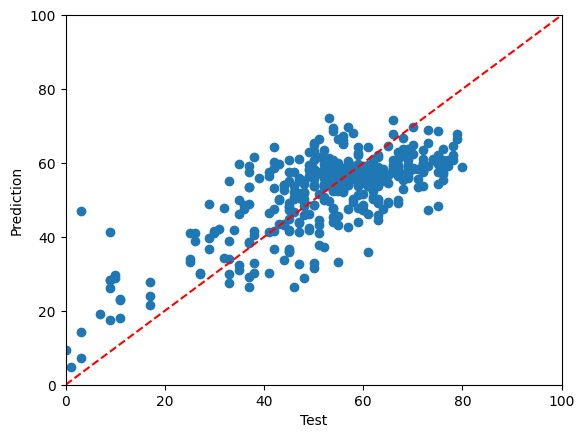

In [46]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([0, 100], [0,100], "--r")

plt.xlabel("Test")
plt.ylabel("Prediction")
plt.xlim(0, 100)
plt.ylim(0, 100)


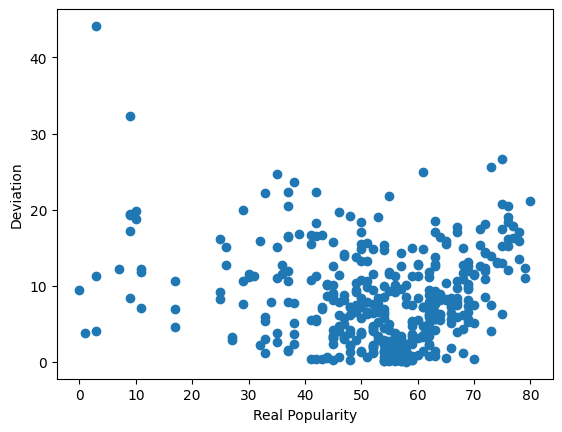

In [47]:
popularity_deviation = np.abs(y_test - y_pred)

plt.scatter(y_test, popularity_deviation)
plt.xlabel("Real Popularity")
plt.ylabel("Deviation")

plt.show()